In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.utils import check_array
from keras.models import load_model
from keras.layers import Bidirectional
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from numpy import array
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers import Dense,LSTM,Dropout,Activation
import os
from pandas import DataFrame
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df=pd.read_csv('Delta_cases.csv')
df.head()

infection
0     624904
1    1196896
2    1724463
3    2168880
4    2654605

In [3]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 

In [4]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_3012/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_3012/3151536076.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [5]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [14]:
n_past = 5
n_future =7
n_features = 1

In [15]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [16]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [173]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 lstm_20 (LSTM)                 [(None, 5, 100),     40800       ['input_6[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_21 (LSTM)                 [(None, 100),        80400       ['lstm_20[0][0]']                
                                 (None, 100),                                               

In [174]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=100,validation_split = 0.2,batch_size=16,verbose=0)

In [11]:
model=load_model("LSTM_3days.h5")
#model=model.save("LSTM_3days.h5")

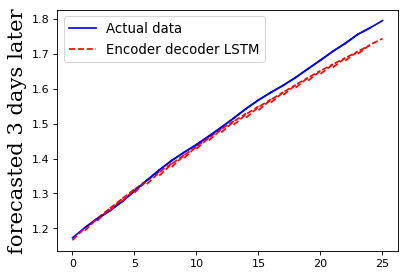

In [12]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred3LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    


In [13]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.02144724213559418
Day  2 :
MAE-E2D2 :  0.016751954537874664
Day  3 :
MAE-E2D2 :  0.01838030889609804


mean 0.018859835189855626


In [14]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  1.3640285385432245
Day  2 :
MAE-E2D2 :  1.0341176615704808
Day  3 :
MAE-E2D2 :  1.1179728830336082


mean 1.1720396943824378


In [15]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   



infection
Day  1 :
MAE-E2D2 :  0.026277993154755704
Day  2 :
MAE-E2D2 :  0.022270426155836076
Day  3 :
MAE-E2D2 :  0.02442338997606184


mean 0.02432393642888454


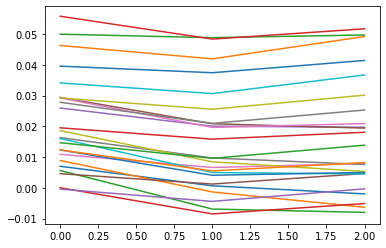

In [16]:
#residual plot

residuals = y_test-pred3LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

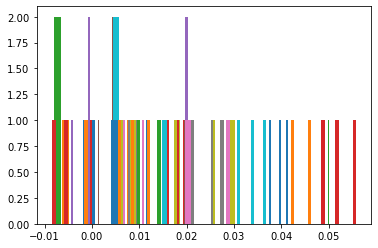

In [17]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

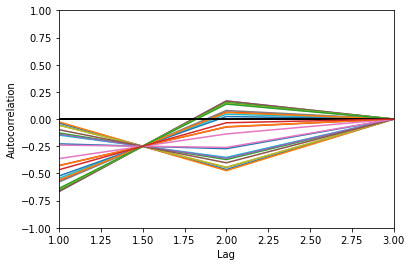

In [18]:
from pandas.plotting import autocorrelation_plot
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

In [9]:
model=load_model("LSTM_5days.h5")
#model=model.save("LSTM_5days.h5")

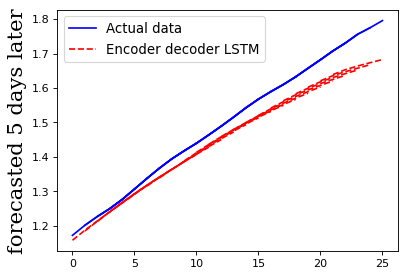

In [10]:
pred5LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"red",linestyle='dashed')
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    #plt.xlabel("days")   
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)


In [11]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.03310557536165432
Day  2 :
MAE-E2D2 :  0.03636987017743711
Day  3 :
MAE-E2D2 :  0.04215921699906849
Day  4 :
MAE-E2D2 :  0.04873169524396262
Day  5 :
MAE-E2D2 :  0.055782217711830825


mean 0.04322971509879068


In [177]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  2.346535583812502
Day  2 :
MAE-E2D2 :  0.7326480729740712
Day  3 :
MAE-E2D2 :  0.7847309062228685
Day  4 :
MAE-E2D2 :  0.8407346630341777
Day  5 :
MAE-E2D2 :  1.4694531971824414


mean 1.2348204846452122


In [178]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


infection
Day  1 :
MAE-E2D2 :  0.03913941918423749
Day  2 :
MAE-E2D2 :  0.015070398878450563
Day  3 :
MAE-E2D2 :  0.0141711883575748
Day  4 :
MAE-E2D2 :  0.01818925192741127
Day  5 :
MAE-E2D2 :  0.03102991296443778


mean 0.023520034262422378


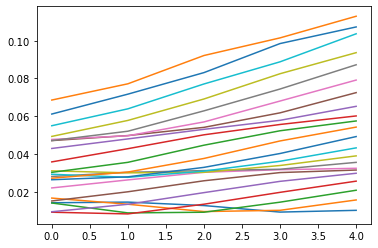

In [12]:
#residual plot

residuals = y_test-pred5LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

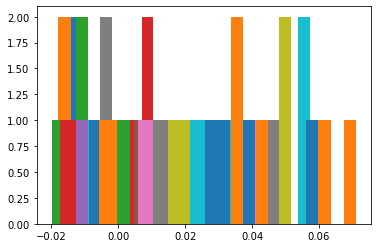

In [180]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

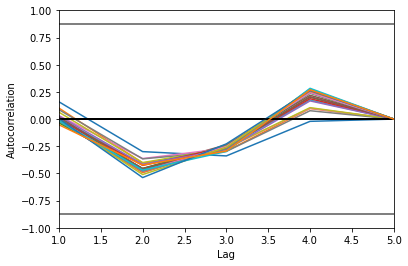

In [181]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

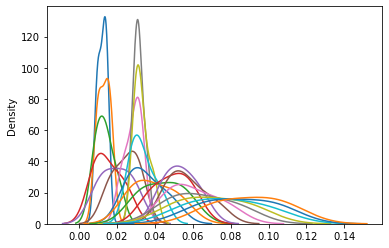

In [13]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [17]:
model=load_model("LSTM_7days.h5")
#model=model.save("LSTM_7days.h5")

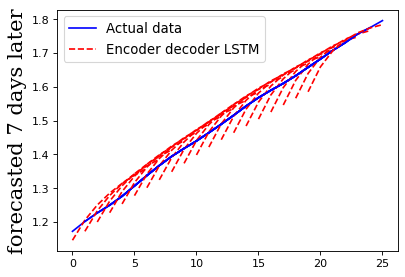

In [18]:
pred7LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)


In [19]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.044754251416920174
Day  2 :
MAE-E2D2 :  0.008393975437159851
Day  3 :
MAE-E2D2 :  0.01856619401625954
Day  4 :
MAE-E2D2 :  0.027021471298592135
Day  5 :
MAE-E2D2 :  0.02705119051302285
Day  6 :
MAE-E2D2 :  0.021837546318655154
Day  7 :
MAE-E2D2 :  0.015611303589629522


mean 0.023319418941462746


In [45]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  3.069177842381014
Day  2 :
MAE-E2D2 :  0.5662516013981945
Day  3 :
MAE-E2D2 :  1.318743731980787
Day  4 :
MAE-E2D2 :  1.8635637826960685
Day  5 :
MAE-E2D2 :  1.8370819030505185
Day  6 :
MAE-E2D2 :  1.4701898290371673
Day  7 :
MAE-E2D2 :  1.031717291593989


mean 1.5938179974482485


In [46]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


infection
Day  1 :
MAE-E2D2 :  0.04737976200687402
Day  2 :
MAE-E2D2 :  0.010448381944433031
Day  3 :
MAE-E2D2 :  0.020141145605073428
Day  4 :
MAE-E2D2 :  0.02810818404208097
Day  5 :
MAE-E2D2 :  0.028474987644638405
Day  6 :
MAE-E2D2 :  0.02395119202694912
Day  7 :
MAE-E2D2 :  0.01713616170776224


mean 0.02509140213968732


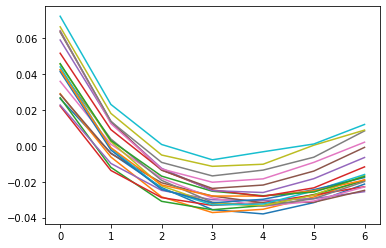

In [20]:
#residual plot

residuals = y_test-pred7LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

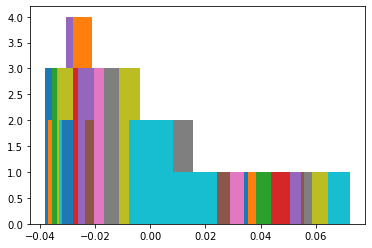

In [48]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

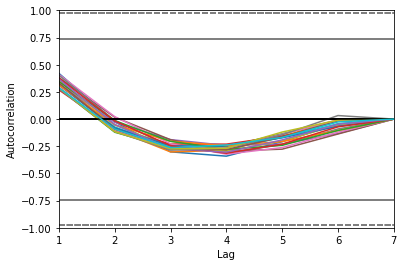

In [49]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

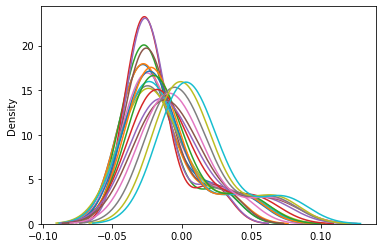

In [21]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [ ]:
#BiLSTM

In [51]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_9996/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_9996/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [52]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [73]:
n_past = 5
n_future =7
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [74]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [44]:
#define model
model = Sequential()
model.add(Bidirectional(LSTM(150, return_sequences=True), input_shape=(n_past, n_features)))
model.add(Bidirectional(LSTM(128,activation='relu')))
model.add(Dense(128))
model.add(Dense(n_future))
model.compile(loss='mean_squared_error', optimizer='Adam')

In [449]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 16)

Epoch 1/100
4/4 [==============================] - 11s 776ms/step - loss: 0.1583 - val_loss: 0.4260
Epoch 2/100
4/4 [==============================] - 0s 81ms/step - loss: 0.0681 - val_loss: 0.3298
Epoch 3/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0371 - val_loss: 0.1982
Epoch 4/100
4/4 [==============================] - 0s 80ms/step - loss: 0.0136 - val_loss: 0.0730
Epoch 5/100
4/4 [==============================] - 0s 79ms/step - loss: 0.0123 - val_loss: 0.0117
Epoch 6/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0044 - val_loss: 0.0262
Epoch 7/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 8/100
4/4 [==============================] - 0s 79ms/step - loss: 0.0019 - val_loss: 0.0350
Epoch 9/100
4/4 [==============================] - 0s 81ms/step - loss: 0.0037 - val_loss: 0.0340
Epoch 10/100
4/4 [==============================] - 0s 83ms/step - loss: 0.0012 - val_loss: 0.0133
Epoch 11/100
4/4 

4/4 [==============================] - 0s 90ms/step - loss: 9.8912e-06 - val_loss: 0.0014
Epoch 81/100
4/4 [==============================] - 0s 77ms/step - loss: 1.0423e-05 - val_loss: 0.0012
Epoch 82/100
4/4 [==============================] - 0s 73ms/step - loss: 9.4727e-06 - val_loss: 0.0012
Epoch 83/100
4/4 [==============================] - 0s 77ms/step - loss: 9.3054e-06 - val_loss: 0.0013
Epoch 84/100
4/4 [==============================] - 0s 79ms/step - loss: 9.2894e-06 - val_loss: 0.0012
Epoch 85/100
4/4 [==============================] - 0s 75ms/step - loss: 9.2671e-06 - val_loss: 0.0013
Epoch 86/100
4/4 [==============================] - 0s 76ms/step - loss: 9.1588e-06 - val_loss: 0.0013
Epoch 87/100
4/4 [==============================] - 0s 77ms/step - loss: 9.0942e-06 - val_loss: 0.0013
Epoch 88/100
4/4 [==============================] - 0s 77ms/step - loss: 9.3280e-06 - val_loss: 0.0012
Epoch 89/100
4/4 [==============================] - 0s 75ms/step - loss: 9.2260e-06 - 

In [55]:
#model.save('bilstm_3days.h5')
model=load_model("bilstm_3days.h5")

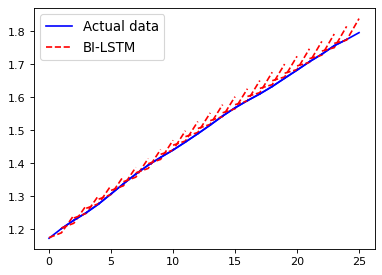

In [56]:
pred3BiLSTM=model.predict(X_test)
pred3BiLSTM = pred3BiLSTM.reshape((pred3BiLSTM.shape[0], pred3BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
      

In [57]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.010543463161266772
Day  2 :
MAE-E2D2 :  0.004130851173600125
Day  3 :
MAE-E2D2 :  0.03261455236185312


mean 0.01576295556557334


In [58]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.7086700715640654
Day  2 :
MAE-E2D2 :  0.29090551267791576
Day  3 :
MAE-E2D2 :  2.1138383480812166


mean 1.0378046441077327


In [59]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.011518571105463015
Day  2 :
MAE-E2D2 :  0.005253151910125926
Day  3 :
MAE-E2D2 :  0.033652612320915466


mean 0.016808111778834803


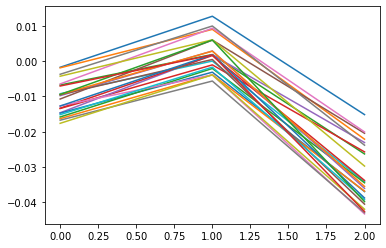

In [60]:
#residual plot

residuals = y_test-pred3BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

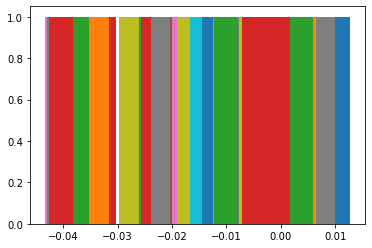

In [61]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

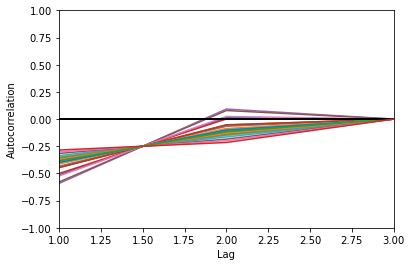

In [62]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)   

In [65]:
#model.save('bilstm_5days.h5')
model=load_model("bilstm_5days.h5")

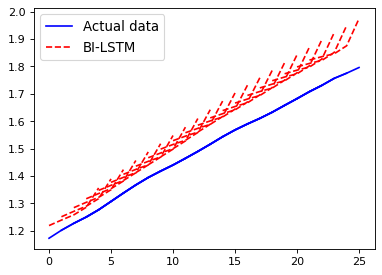

In [66]:
pred5BiLSTM=model.predict(X_test)
pred5BiLSTM= pred5BiLSTM.reshape((pred5BiLSTM.shape[0], pred5BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
      

In [67]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.08606050624026884
Day  2 :
MAE-E2D2 :  0.07697010665347886
Day  3 :
MAE-E2D2 :  0.06658272748737616
Day  4 :
MAE-E2D2 :  0.07020173859219404
Day  5 :
MAE-E2D2 :  0.13040993175390347


mean 0.08604500214544428


In [68]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  5.851251627532179
Day  2 :
MAE-E2D2 :  5.1333673730231535
Day  3 :
MAE-E2D2 :  4.357283259173649
Day  4 :
MAE-E2D2 :  4.513340909092016
Day  5 :
MAE-E2D2 :  8.300797715253978


mean 5.6312081768149955


In [69]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.08875235768522985
Day  2 :
MAE-E2D2 :  0.0797411040617536
Day  3 :
MAE-E2D2 :  0.06933026849716761
Day  4 :
MAE-E2D2 :  0.07332856535217273
Day  5 :
MAE-E2D2 :  0.13422204580169672


mean 0.0890748682796041


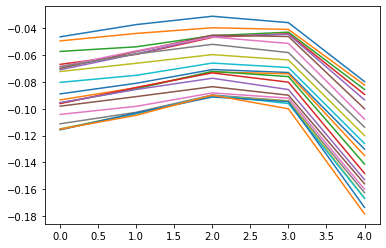

In [70]:
#residual plot

residuals = y_test-pred5BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

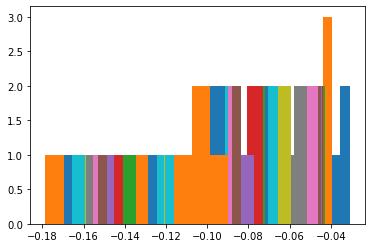

In [71]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

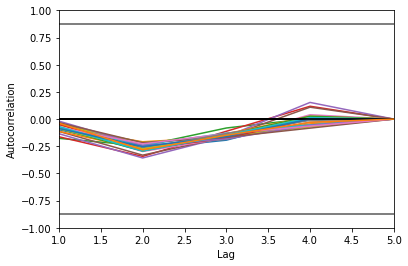

In [72]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [75]:
#model.save('bilstm_7days.h5')
model=load_model("bilstm_7days.h5")

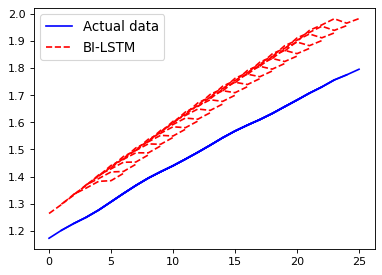

In [76]:
pred7BiLSTM=model.predict(X_test)
pred7BiLSTM = pred7BiLSTM.reshape((pred7BiLSTM.shape[0], pred7BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
#plt.legend()       

In [77]:
#RMSE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.1502663944399371
Day  2 :
MAE-E2D2 :  0.15933730996034784
Day  3 :
MAE-E2D2 :  0.1735433282191971
Day  4 :
MAE-E2D2 :  0.16996130112494712
Day  5 :
MAE-E2D2 :  0.16820698775614112
Day  6 :
MAE-E2D2 :  0.13651811602893035
Day  7 :
MAE-E2D2 :  0.1342952932061879


mean 0.15601839010509838


In [78]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  10.424488457546973
Day  2 :
MAE-E2D2 :  10.85730362084019
Day  3 :
MAE-E2D2 :  11.633130498708855
Day  4 :
MAE-E2D2 :  11.193576364376554
Day  5 :
MAE-E2D2 :  10.886837579112152
Day  6 :
MAE-E2D2 :  8.672775626831447
Day  7 :
MAE-E2D2 :  8.404744911096046


mean 10.296122436930318


In [79]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    



infection
Day  1 :
MAE-E2D2 :  0.1540682434247241
Day  2 :
MAE-E2D2 :  0.16345833846296565
Day  3 :
MAE-E2D2 :  0.17769571107695767
Day  4 :
MAE-E2D2 :  0.17430792770185535
Day  5 :
MAE-E2D2 :  0.1727909696504271
Day  6 :
MAE-E2D2 :  0.1411208429959791
Day  7 :
MAE-E2D2 :  0.13866550865815477


mean 0.1603010774244377


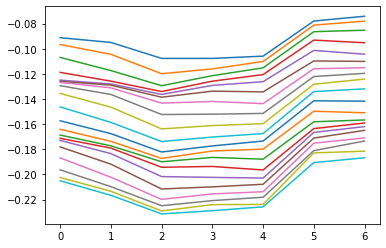

In [80]:
#residual plot

residuals = y_test-pred7BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

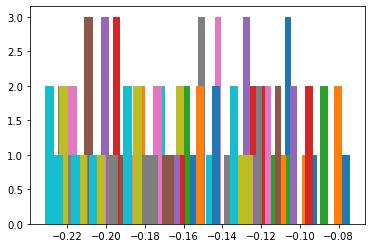

In [81]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

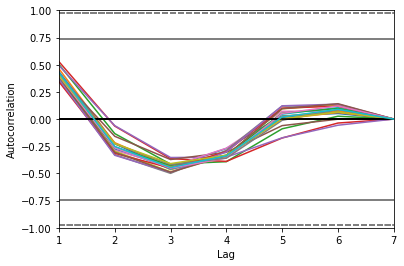

In [82]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#ConvLSTM

In [12]:
n_past=4
n_future=7
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):]
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s
    
    
    
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y) 


X_train, y_train = split_series(train.values,n_past, n_future)
X_test, y_test = split_series(test.values,n_past, n_future)

n_features = 1
n_seq = 2
n_steps = 2
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_3096/427068468.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_3096/427068468.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [485]:
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

In [486]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False)

Epoch 1/100
5/5 [==============================] - 6s 140ms/step - loss: 0.1997 - val_loss: 0.4811
Epoch 2/100
5/5 [==============================] - 0s 24ms/step - loss: 0.1924 - val_loss: 0.4759
Epoch 3/100
5/5 [==============================] - 0s 28ms/step - loss: 0.1868 - val_loss: 0.4697
Epoch 4/100
5/5 [==============================] - 0s 25ms/step - loss: 0.1815 - val_loss: 0.4632
Epoch 5/100
5/5 [==============================] - 0s 29ms/step - loss: 0.1762 - val_loss: 0.4560
Epoch 6/100
5/5 [==============================] - 0s 22ms/step - loss: 0.1708 - val_loss: 0.4481
Epoch 7/100
5/5 [==============================] - 0s 23ms/step - loss: 0.1652 - val_loss: 0.4394
Epoch 8/100
5/5 [==============================] - 0s 29ms/step - loss: 0.1594 - val_loss: 0.4298
Epoch 9/100
5/5 [==============================] - 0s 27ms/step - loss: 0.1533 - val_loss: 0.4191
Epoch 10/100
5/5 [==============================] - 0s 26ms/step - loss: 0.1467 - val_loss: 0.4071
Epoch 11/100
5/5 [

Epoch 82/100
5/5 [==============================] - 0s 24ms/step - loss: 8.7208e-05 - val_loss: 0.0025
Epoch 83/100
5/5 [==============================] - 0s 23ms/step - loss: 8.5245e-05 - val_loss: 0.0025
Epoch 84/100
5/5 [==============================] - 0s 25ms/step - loss: 8.3291e-05 - val_loss: 0.0025
Epoch 85/100
5/5 [==============================] - 0s 25ms/step - loss: 8.1369e-05 - val_loss: 0.0025
Epoch 86/100
5/5 [==============================] - 0s 24ms/step - loss: 7.9504e-05 - val_loss: 0.0025
Epoch 87/100
5/5 [==============================] - 0s 23ms/step - loss: 7.7695e-05 - val_loss: 0.0025
Epoch 88/100
5/5 [==============================] - 0s 23ms/step - loss: 7.5925e-05 - val_loss: 0.0025
Epoch 89/100
5/5 [==============================] - 0s 25ms/step - loss: 7.4213e-05 - val_loss: 0.0025
Epoch 90/100
5/5 [==============================] - 0s 22ms/step - loss: 7.2555e-05 - val_loss: 0.0025
Epoch 91/100
5/5 [==============================] - 0s 23ms/step - loss: 

In [84]:
#model.save('ConvLSTM_3days.h5')
model=load_model("ConvLSTM_3days.h5")

In [85]:
pred3ConvLSTM=model.predict(X_test)

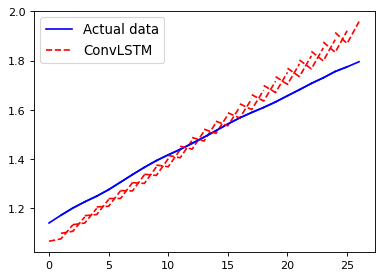

In [86]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [87]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3ConvLSTM = pred3ConvLSTM.reshape((pred3ConvLSTM.shape[0], pred3ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.06432746607521375
Day  2 :
MAE-E2D2 :  0.0516958931356162
Day  3 :
MAE-E2D2 :  0.06359136113916505


mean 0.059871573449998335


In [88]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  4.284151711920471
Day  2 :
MAE-E2D2 :  3.636817198633155
Day  3 :
MAE-E2D2 :  4.04264980359895


mean 3.987872904717525


In [90]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    




infection
Day  1 :
MAE-E2D2 :  0.07688829458419366
Day  2 :
MAE-E2D2 :  0.05906854150097085
Day  3 :
MAE-E2D2 :  0.07711916030458305


mean 0.07102533212991585


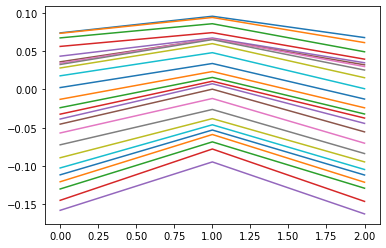

In [91]:
#residual plot

residuals = y_test-pred3ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

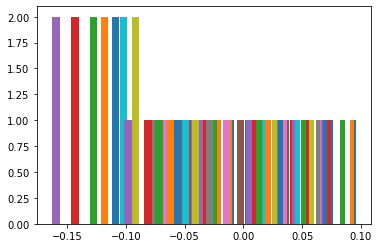

In [92]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

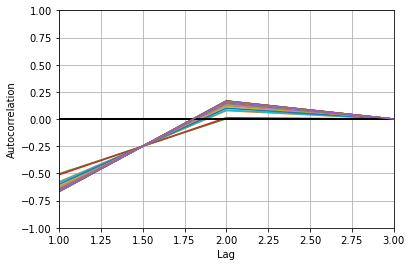

In [93]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [7]:
#model.save('ConvLSTM_5days.h5')
model=load_model("ConvLSTM_5days.h5")

In [8]:
pred5ConvLSTM=model.predict(X_test)

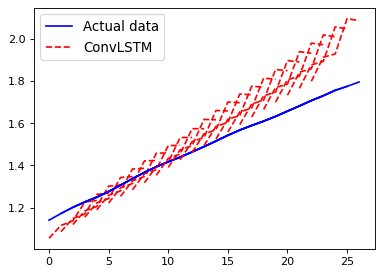

In [9]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [10]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5ConvLSTM = pred5ConvLSTM.reshape((pred5ConvLSTM.shape[0], pred5ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.04976085440555204
Day  2 :
MAE-E2D2 :  0.07121396563771518
Day  3 :
MAE-E2D2 :  0.06973835185191875
Day  4 :
MAE-E2D2 :  0.14838396564298567
Day  5 :
MAE-E2D2 :  0.12372631014346315


mean 0.09256468953632695


In [11]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  3.585616857995562
Day  2 :
MAE-E2D2 :  4.593882883965733
Day  3 :
MAE-E2D2 :  4.463676556514342
Day  4 :
MAE-E2D2 :  9.22257435682399
Day  5 :
MAE-E2D2 :  7.513268740872679


mean 5.875803879234462


In [100]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.05702663881183982
Day  2 :
MAE-E2D2 :  0.09033194760353762
Day  3 :
MAE-E2D2 :  0.08636460971787828
Day  4 :
MAE-E2D2 :  0.1780640706682859
Day  5 :
MAE-E2D2 :  0.15447076495275208


mean 0.11325160635085874


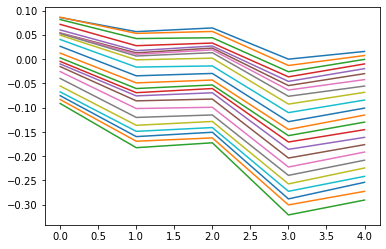

In [101]:
#residual plot

residuals = y_test-pred5ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

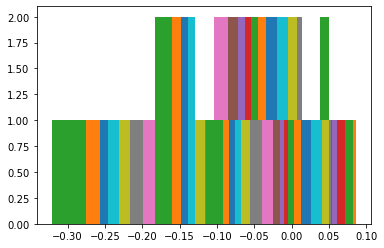

In [102]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

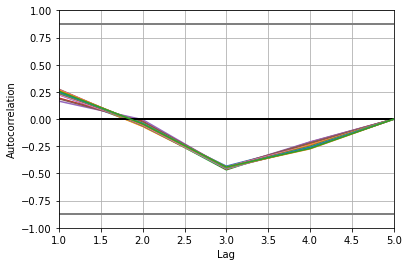

In [103]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [13]:
#model.save('ConvLSTM_7days.h5')
model=load_model("ConvLSTM_7days.h5")

In [14]:
pred7ConvLSTM=model.predict(X_test)

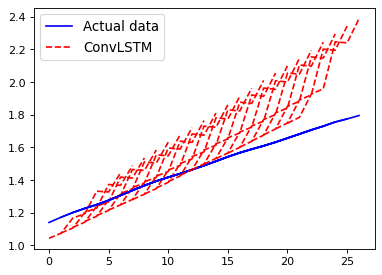

In [15]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [16]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7ConvLSTM = pred7ConvLSTM.reshape((pred7ConvLSTM.shape[0], pred7ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.052819959420577454
Day  2 :
MAE-E2D2 :  0.05439182955430396
Day  3 :
MAE-E2D2 :  0.09000430405042252
Day  4 :
MAE-E2D2 :  0.09330111898901292
Day  5 :
MAE-E2D2 :  0.2722990778082605
Day  6 :
MAE-E2D2 :  0.24049695356602302
Day  7 :
MAE-E2D2 :  0.35234316583382974


mean 0.16509377274606146


In [17]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  3.9092055350544497
Day  2 :
MAE-E2D2 :  3.8961843891774186
Day  3 :
MAE-E2D2 :  5.750314390270953
Day  4 :
MAE-E2D2 :  5.8610669592980615
Day  5 :
MAE-E2D2 :  17.351688485005116
Day  6 :
MAE-E2D2 :  14.985631759105264
Day  7 :
MAE-E2D2 :  21.923163613325546


mean 10.525322161605258


In [110]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.060640427555170906
Day  2 :
MAE-E2D2 :  0.06227058990485733
Day  3 :
MAE-E2D2 :  0.11422312815249538
Day  4 :
MAE-E2D2 :  0.11883844857757188
Day  5 :
MAE-E2D2 :  0.3005575518183425
Day  6 :
MAE-E2D2 :  0.27265428971902617
Day  7 :
MAE-E2D2 :  0.3790314763487446


mean 0.1868879874394584


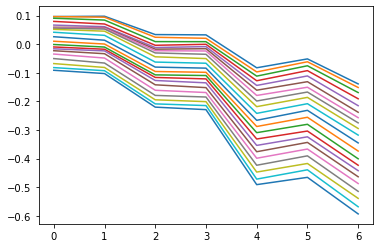

In [111]:
#residual plot

residuals = y_test-pred7ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

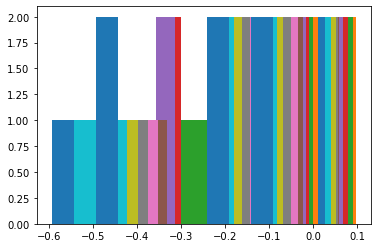

In [112]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

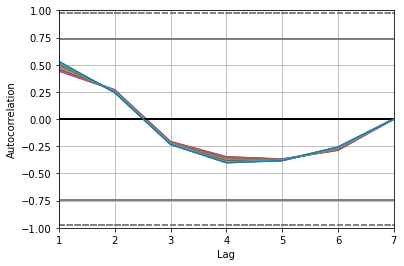

In [113]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#GRU

In [6]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_3012/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_3012/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [7]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [8]:
n_past = 5
n_future =3
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [9]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

In [26]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (85, 5, 1)
y_train.shape:  (85, 3)
X_test.shape:  (24, 5, 1)
y_test.shape:  (24, 3)


In [27]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = n_future)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [553]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        )
    return history
history_gru = fit_model(model_gru)


Epoch 1/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0024 - val_loss: 1.8827e-04
Epoch 2/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 3/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 4/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 5.3653e-04
Epoch 6/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 7/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0028 - val_loss: 6.6878e-04
Epoch 8/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 9/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 6.6887e-04
Epoch 10/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 0.0015
Epo

In [10]:
#model_gru.save('GRU_3days.h5')
model_gru=load_model("GRU_3days.h5")

In [11]:
pred3GRU=model_gru.predict(X_test)

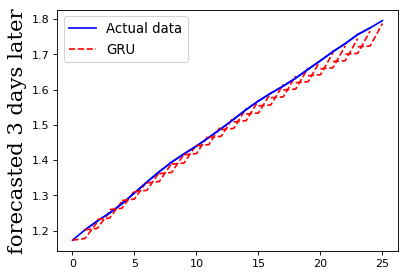

In [12]:
from matplotlib.pyplot import figure
font1 = {'family':'Serif','color':'black','size':19}

figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later",fontdict = font1)
    plt.legend(['Actual data','GRU'],fontsize=12)


In [31]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3GRU = pred3GRU.reshape((pred3GRU.shape[0], pred3GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.010478696533125886
Day  2 :
MAE-E2D2 :  0.03002992968402955
Day  3 :
MAE-E2D2 :  0.004934990354691193


mean 0.015147872190615544


In [50]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


infection
Day  1 :
MAE-E2D2 :  0.6607165675051486
Day  2 :
MAE-E2D2 :  1.9595529282713786
Day  3 :
MAE-E2D2 :  0.32150502860690044


mean 0.9805915081278093


In [123]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.014265408277872238
Day  2 :
MAE-E2D2 :  0.03196443995694741
Day  3 :
MAE-E2D2 :  0.005731320731214376


mean 0.017320389655344676


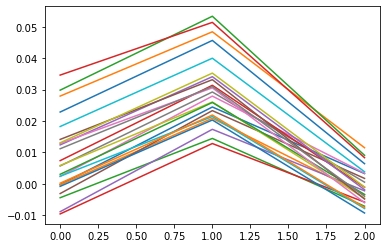

In [32]:
#residual plot

residuals = y_test-pred3GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

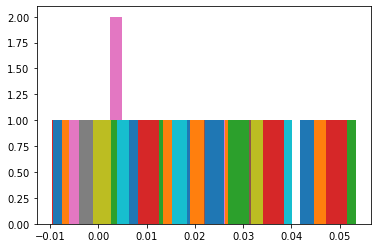

In [125]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

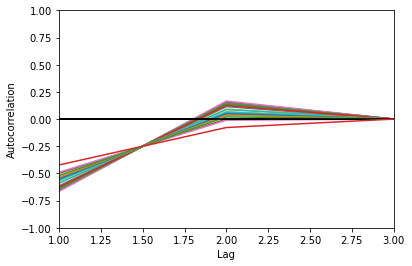

In [126]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

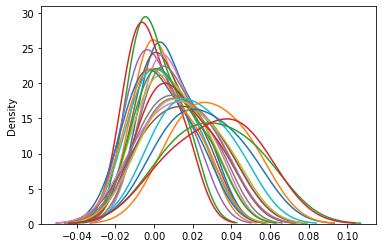

In [33]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [30]:
#model_gru.save('GRU_5days.h5')
model_gru=load_model("GRU_5days.h5")

In [31]:
pred5GRU=model_gru.predict(X_test)


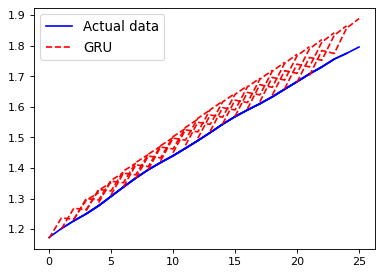

In [32]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','GRU'],fontsize=12)


In [34]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5GRU = pred5GRU.reshape((pred5GRU.shape[0], pred5GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.004488736747577418
Day  2 :
MAE-E2D2 :  0.05299520575757987
Day  3 :
MAE-E2D2 :  0.020892239755789355
Day  4 :
MAE-E2D2 :  0.06876384697884066
Day  5 :
MAE-E2D2 :  0.0718130010333141


mean 0.04379060605462028


In [35]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


infection
Day  1 :
MAE-E2D2 :  0.3162024026016834
Day  2 :
MAE-E2D2 :  3.5995590007893568
Day  3 :
MAE-E2D2 :  1.3750410331694614
Day  4 :
MAE-E2D2 :  4.475339408555612
Day  5 :
MAE-E2D2 :  4.57544003169148


mean 2.868316375361519


In [134]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.005559832419690631
Day  2 :
MAE-E2D2 :  0.053501225332294726
Day  3 :
MAE-E2D2 :  0.022008998711862845
Day  4 :
MAE-E2D2 :  0.07004909755863245
Day  5 :
MAE-E2D2 :  0.07381105610928239


mean 0.04498604202635261


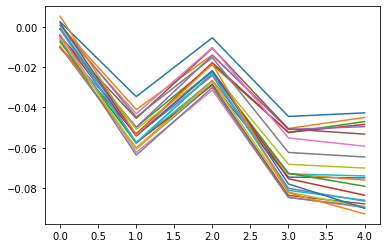

In [135]:
#residual plot

residuals = y_test-pred5GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

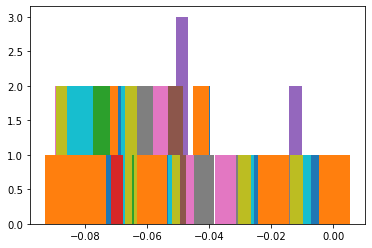

In [136]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

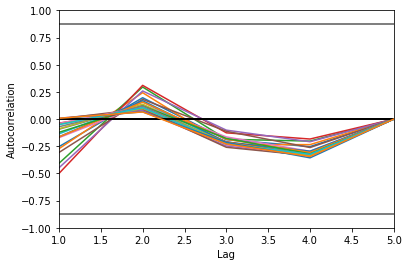

In [137]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [38]:
#model_gru.save('GRU_7days.h5')
model_gru=load_model("GRU_7days.h5")

In [39]:
pred7GRU=model_gru.predict(X_test)


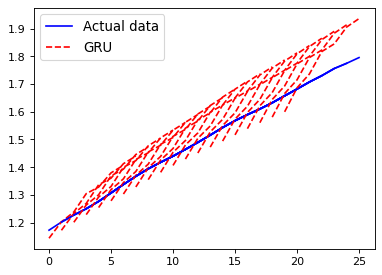

In [40]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7days later") 
    plt.legend(['Actual data','GRU'],fontsize=12)

In [41]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7GRU = pred7GRU.reshape((pred7GRU.shape[0], pred7GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.03824685471892213
Day  2 :
MAE-E2D2 :  0.009115020398122509
Day  3 :
MAE-E2D2 :  0.026826304369709807
Day  4 :
MAE-E2D2 :  0.07586611870612388
Day  5 :
MAE-E2D2 :  0.0761503497537455
Day  6 :
MAE-E2D2 :  0.10781943920436066
Day  7 :
MAE-E2D2 :  0.11221327435395403


mean 0.0637481945007055


In [42]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


infection
Day  1 :
MAE-E2D2 :  2.647114826928114
Day  2 :
MAE-E2D2 :  0.6333268228309347
Day  3 :
MAE-E2D2 :  1.798112063758573
Day  4 :
MAE-E2D2 :  5.032083620845255
Day  5 :
MAE-E2D2 :  4.949524982643787
Day  6 :
MAE-E2D2 :  6.90212263427614
Day  7 :
MAE-E2D2 :  7.060873588967563


mean 4.146165505750052


In [43]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.03963231038549094
Day  2 :
MAE-E2D2 :  0.010096309267597742
Day  3 :
MAE-E2D2 :  0.027749421199821378
Day  4 :
MAE-E2D2 :  0.07684292343937371
Day  5 :
MAE-E2D2 :  0.0775860385391918
Day  6 :
MAE-E2D2 :  0.10958683490943981
Day  7 :
MAE-E2D2 :  0.11441588206312217


mean 0.06512995997200535


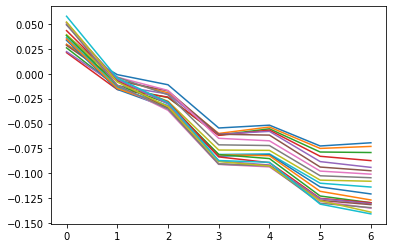

In [147]:
#residual plot

residuals = y_test-pred7GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

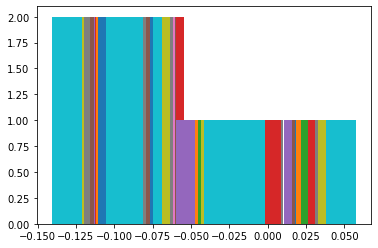

In [148]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

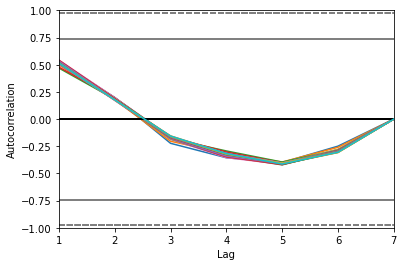

In [149]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

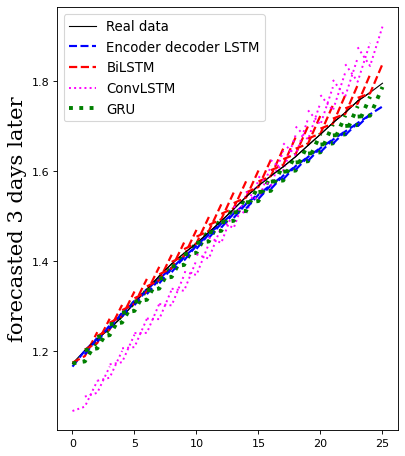

In [108]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
font1 = {'family':'Serif','color':'black','size':19}
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black",linewidth=1)
    plt.plot(range(i,i+n_future),pred3LSTM[i],"blue",linestyle='dashed',linewidth=1.95)
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed',linewidth=2)
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"magenta",linestyle='dotted',linewidth=1.75)
    plt.plot(range(i,i+n_future),pred3GRU[i],"green",linestyle='dotted',linewidth=3.5)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()

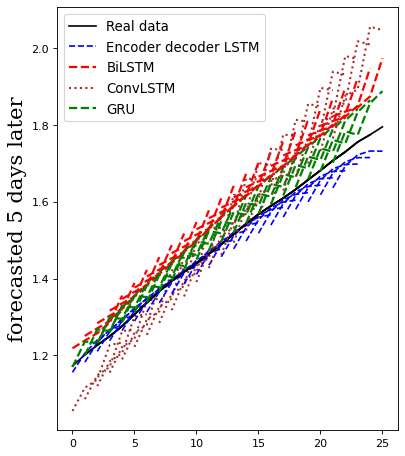

In [182]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"blue",linestyle='dashed')
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dashed',linewidth=2)
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"brown",linestyle='dotted',linewidth=1.85)
    plt.plot(range(i,i+n_future),pred5GRU[i],"green",linestyle='dashed',linewidth=2)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()

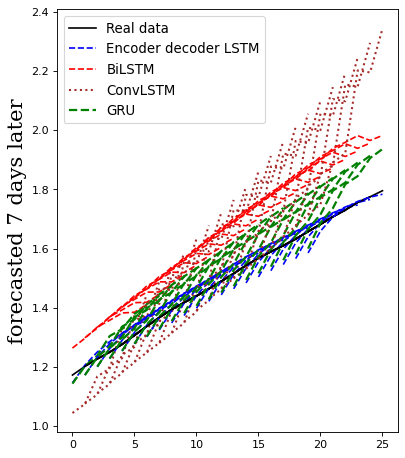

In [150]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"blue",linestyle='dashed')
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"brown",linestyle='dotted',linewidth=1.85)
    plt.plot(range(i,i+n_future),pred7GRU[i],"green",linestyle='dashed',linewidth=2)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()